In [1]:
!pip install --upgrade scikit-learn
!pip install --upgrade numpy
#do not upgrade matplotlib to 3.0.2 yet https://github.com/matplotlib/matplotlib/issues/6092

    100% |████████████████████████████████| 5.3MB 5.3MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2
    100% |████████████████████████████████| 13.9MB 2.7MB/s 
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


# Clustering

Οι αλγόριθμοι clustering ανήκουν στην κατηγορία της **μη-επιβλεπόμενης μάθησης**. Σε αντίθεση με ό,τι έχουμε δει μέχρι στιγμής, στα προβλήματα αυτά τα δεδομένα μας **δεν συνοδεύονται από ετικέτες**. Αυτό σημαίνει ότι δεν έχουμε τις γνωστές μετρικές (π.χ. accuracy) για να αξιολογήσουμε αντικειμενικά την επίδοση του αλγορίθμου. Χωρίς αυτές είναι αδύνατη η εκπαίδευση των αλγορίθμων με τις τεχνικές που έχουμε μάθει (backpropagation/gradient descent). Αντίθετα, στα προβλήματα αυτά θέλουμε ο αλγόριθμος να βρει μόνος του τη δομή (την υποκείμενεη κατανομή - underlying distribution) των δεδομένων εισόδου.

Η [συσταδοποίηση](https://el.wikipedia.org/wiki/%CE%A3%CF%85%CF%83%CF%84%CE%B1%CE%B4%CE%BF%CF%80%CE%BF%CE%AF%CE%B7%CF%83%CE%B7) (clustering) είναι ένα πρόβλημα το οποίο προσπαθεί να χωρίσει τα δεδομένα εισόδου σε ομάδες/συστάδες (clusters).

![](https://cdn-images-1.medium.com/max/1600/0*9ksfYh14C-ARETav.)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Στη μη επιβλεπόμενη μάθηση δεν έχουμε κάποιο σύνολο δεδομένων εκπαίδευσης στο οποίο να γνωρίζουμε εκ των προτέρων σε ποια κατηγορία ανήκει το κάθε παράδειγμα. **Δεν γνωρίζουμε καν σε πόσες διαφορετικές κατηγορίες ανήκουν τα δεδομένα μας!**

Θα ξεκινήσουμε με ένα εύκολο παράδειγμα, του οποίου τα δεδομένα μπορούμε και με το μάτι εύκολα να χωρίσουμε σε 2 κατηγορίες. Θα βάλουμε $Ν=100$ σημεία στο χώρο, 50 απ' τα οποία θα ανήκουν σε κάθε κατηγορία. Σκοπός μας είναι να υλοποιήσουμε έναν αλγόριθμο ο οποίος θα μπορεί από μόνος του να χωρίζει τα δεδομένα αυτά σε κατηγορίες. 

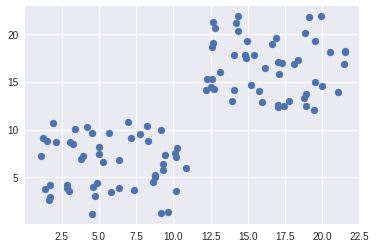

In [3]:
#                                                  CODE:
#                              --------------------------------------------

np.random.seed(55) # για να αναπαράγονται τα αποτελέσματα...

p1 = np.random.rand(50,2) * 10 + 1 # 100 τυχαίοι αριθμοί από ομοιόμορφη κατανομή στο διάστημα [1,11), αποθηκευμένοι σε πίνακα διαστάσεων 50x2.
p2 = np.random.rand(50,2) * 10 + 12 # 100 τυχαίοι αριθμοί από ομοιόμορφη κατανομή στο διάστημα [12,22), αποθηκευμένοι σε πίνακα διαστάσεων 50x2.

points = np.concatenate([p1, p2]) # ενώνουμε τους αριθμούς σε έναν ενιαίο πίνακα διαστάσεων 100x2
                                  # η πρώτη στήλη του πίνακα αντιστοιχεί στη συντεταγμένη x ενώ η δεύτερη στην y
                                  # δηλαδή η 30η γραμμή του πίνακα αντιπροσωπεύει τις 2 συντεταγμένες του 30ου παραδείγματος 

#                                                PLOTTING:
#                              --------------------------------------------

plt.scatter(points[:,0], points[:,1]) # για να σχεδιάσουμε τη γραφική παράσταση διακριτών σημείων χρησιμοποιούμε την scatter
                                      # τα 2 της ορίσματα είναι οι συντεταγμένες x και y όλων των σημείων

## K-Means

Ο πιο απλός αλγόριθμος clustering είναι ο **[k-means](https://en.wikipedia.org/wiki/K-means_clustering)**, ο οποίος θα δούμε βήμα βήμα πώς δουλεύει.

Η λειτουργία του k-means είναι απλή. Ορίζουμε πρώτα τον αριθμό των ομάδων (**k**) στις οποίες θέλουμε να χωρίσει ο αλγόριθμος τα δεδομένα μας. Η λογική του αλγορίθμου είναι ότι χωρίζει ομάδες με βάση σημεία στο χώρο, τα οποία αναπαριστούν τα κέντρα των ομάδων αυτών. Τα κέντρα αρχικοποιούνται τυχαία. Έπειτα ελέγχουμε την απόσταση του κάθε σημείου από τα δεδομένα μας με το κάθε κέντρο. Το κέντρο το οποίο είναι πιο κοντά στο σημείο είναι και αυτό στου οποίου την ομάδα θεωρούμε ότι ανήκει. Τη διαδικασία αυτή την ομάζουμε ανάθεση (assignment). Τέλος, για κάθε ομάδα, υπολογίζουμε το μέσο όρο όλων των σημείων της και μετακινούμε το κέντρο στο σημείο αυτό. Τη διαδικασία αυτή την ονομάζουμε ενημέρωση (update). Η ανάθεση των σημείων και η ενημέρωση των κέντρων επαναλαμβάνεται έως ότου έρθει σε σύγκλιση ο αλγόριθμος.

![](http://stanford.edu/~cpiech/cs221/img/kmeansViz.png)

Στο παραπάνω σχήμα:

- (α):  Δεδομένα εισόδου
- (β):  Τυχαία αρχικοποίηση κέντρων
- (γ):  Πρώτη ανάθεση σημείων σε ομάδες
- (δ):  Πρώτη ενημέρωση κέντρων
- (ε):  Δεύτερη ανάθεση
- (στ): Δεύτερη ενημέρωση

Μπορούμε να δούμε ολόκληρη τη διαδικασία της εκπαίδευσης και στο παρακάτω σχήμα.

![](https://www.projectrhea.org/rhea/images/e/ef/RunyanKmeans.gif)

Η μόνη παράμετρος που χρειάζεται ο αλγόριθμος αυτός για να δουλέψει είναι το **k**, το οποίο είναι ο αριθμός των ομάδων στις οποίες θέλουμε να χωρίσει τα δεδομένα. Το πρώτο βήμα μόλις του δώσουμε το **k**, είναι να φτιάξει **k** τυχαία σημεία στο χώρο, τα οποία αναπαριστούν τα κέντρα των ομάδων.

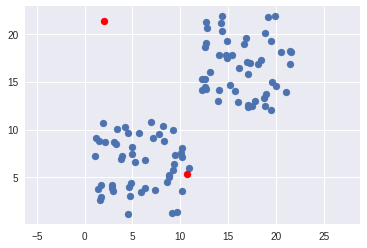

In [4]:
#                                                  CODE:
#                              --------------------------------------------

k = 2 # υπερπαράμετρος του k-means --> ο αριθμός των cluster που θα ψάξει να βρει ο αλγόριθμος

np.random.seed(55)
centroids = np.random.rand(k,2) * 22 # ΒΗΜΑ 1: φτιάχνει τυχαία 2 σημεία στο ίδιο διάστημα που βρίσκονται και τα δεδομένα μας

#                                                PLOTTING:
#                              --------------------------------------------

plt.scatter(points[:,0], points[:,1])                        # τυπώνουμε τα σημεία με μπλε (default)
plt.scatter(centroids[:,0], centroids[:,1], color='r', s=50) # και τα 2 κέντρα με κόκκινο χρώμα και μεγαλύτερο μέγεθος
axes_scaling = plt.axis('equal') # o λόγος των δύο αξόνων να είναι 1 https://matplotlib.org/gallery/subplots_axes_and_figures/axis_equal_demo.html

Για να μπορέσουμε να συνεχίσουμε, χρειαζόμαστε έναν τρόπο να υπολογίζουμε πόσο κοντά είναι το ένα σημείο στο άλλο. Το μέτρο που θα χρησιμοποιήσουμε για το σκοπό αυτό είναι η [Ευκλείδεια απόσταση](https://en.wikipedia.org/wiki/Euclidean_distance). Για τις 2 διαστάσεις η απόσταση 2 σημείων $a$ και $b$ υπολογίζεται ως:

$$
d \left( a, b \right) = \sqrt{ \left( a_x - b_x \right)^2 + \left( a_y - b_y \right)^2}
$$

Πέρα από τη γνωστή σε εμάς κι απ' τη γεωμετρία Ευκλείδεια απόσταση, υπάρχουν και [άλλες][1] συναρτήσεις που θα μπορούσαμε να χρησιμοποιήσουμε για τον υπολογισμό της απόστασης.

[1]: https://en.wikipedia.org/wiki/Metric_(mathematics)

In [5]:
#                                                  CODE:
#                              --------------------------------------------

def euclidean_distance(point1, point2):
    # υλοποίηση της Ευκλείδειας απόστασης από τον παραπάνω τύπο
    # δέχεται 2 σημεία (που το καθένα έχει 2 συντεταγμένες) και επιστρέφει την απόσταση
    return np.sqrt( (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2 )

print('the distance from (5,2) to (2,5) is:', euclidean_distance((5,2), (2,5)))
print('the distance from (3,3) to (3,3) is:', euclidean_distance((3,3), (3,3)))
print('the distance from (1,12) to (12,15) is:', euclidean_distance((1,12), (12,15)))

the distance from (5,2) to (2,5) is: 4.242640687119285
the distance from (3,3) to (3,3) is: 0.0
the distance from (1,12) to (12,15) is: 11.40175425099138


Tip: Αντί της παραπάνω συνάρτησης θα μπορούσαμε εναλλακτικά να χρησιμοποιήσουμε τη μέθοδο [pdist](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.spatial.distance.pdist.html) από τη βιβλιοθήκη scipy.spatial.distance.

Το δεύτερο βήμα του αλγορίθμου είναι να υπολογίσει για κάθε σημείο πόσο απέχει από κάθε κέντρο. Για τον υπολογισμό αυτό θα χρησιμοποιήσουμε τη βοηθητική συνάρτηση που ορίσαμε παραπάνω.

In [6]:
#                                                  CODE:
#                              --------------------------------------------

def calc_distances(centroids, points):
    # δέχεται δύο σύνολα σημείων, το πρώτο είναι το σύνολο των κέντρων των cluster
    # ενώ το δεύτερο είναι το σύνολο των σημείων που θέλουμε να ομαδοποιήσουμε
    distances = np.zeros((len(centroids), len(points))) # φτιάχνουμε έναν πίνακα (διαστάσεων (k x N)) που θα αποθηκεύσει τις αποστάσεις.
    for i in range(len(centroids)):
        for j in range(len(points)):
            distances[i,j] = euclidean_distance(centroids[i], points[j])
    return distances
    # Το παραπάνω μπορεί να γραφτεί ως εξής:
    # return np.reshape(np.array([euclidean_distance(centroids[i], points[j]) for i in range(len(centroids)) for j in range(len(points))]), (len(centroids), len(points)))
    

print('first 10 distances from the first centroid:')
print(calc_distances(centroids, points)[0, :10])
print('...')

first 10 distances from the first centroid:
[10.66051639 18.34697375 18.03210907 21.35516886 12.70487826 12.63056227
 14.22553545 13.44270615 17.74860179 11.96433364]
...


Έπειτα, χρησιμοποιεί τις αποστάσεις αυτές για να δει σε ποια ομάδα ανήκει το κάθε σημείο (δηλ. σε ποιο κέντρο βρίσκεται πιο κοντά).

In [7]:
#                                                   CODE:
#                              --------------------------------------------

def assign_cluster(centroids, points):
    distances = calc_distances(centroids, points)
    return np.argmin(distances, axis=0)

print('which cluster does each point belong to?')
print(assign_cluster(centroids, points))

which cluster does each point belong to?
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1]


Επειδή έχουμε $k=2$ ο διαχωρισμός των 2 ομάδων γίνεται γεωμετρικά από τη μεσοκάθετο. Τις γραμμές (ή επίπεδα σε χώρους μεγαλύτερων διαστάσεων) που χωρίζουν τις ομάδες τις αποκαλούμε [decision boundaries](https://en.wikipedia.org/wiki/Decision_boundary). Για λόγους εξοικείωσης με το matplotlib θα προσπαθήσουμε να σχεδιάσουμε τις ομάδες και τη μεσοκάθετο.

Όσον αφορά την επιλογή των χρωμάτων, η matplotlib έχει δώσει σε αρκετά χρώματα [ονόματα](https://matplotlib.org/examples/color/named_colors.html) με τα οποία μπορούμε να τα καλέσουμε. Αυτός είναι και ο πιο εύκολος τρόπος να διαλέξουμε χρώμα. Δίνει βέβαια τη δυνατότητα να [δημιουργήσουμε](https://matplotlib.org/api/colors_api.html) και δικά μας (π.χ. αν γνωρίζουμε τις RGB ή HSV τιμές του χρώματος).


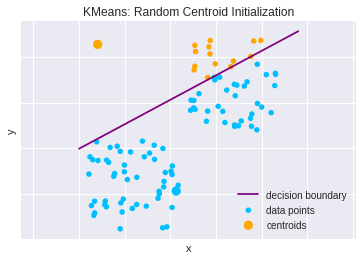

In [8]:
#                                                PLOTTING:
#                              --------------------------------------------

# Αρχικά θα υπολογίσουμε τη συνάρτηση της μεσοκαθέτου
def generate_perp_bisector(centroids):
    midpoint = ((centroids[0,0]+centroids[1,0])/2, (centroids[0,1]+centroids[1,1])/2)  # το μέσο των 2 κέντρων
    slope = (centroids[1,1]-centroids[0,1]) / (centroids[1,0]-centroids[0,0])          # η κλίση της ευθείας που ενώνει τα 2 κέντρα
    perpendicular = -1/slope                                                           # η κάθετος στην κλίση αυτή
    #perpendicular = slope
    return lambda x:  perpendicular*(x-midpoint[0]) + midpoint[1]             # η συνάρτηση της μεσοκαθέτου
                                                                              #lambda είναι μια ανώνυμη συνάρτηση δλδ lambda argument: manipulate(argument)


perp_bisector = generate_perp_bisector(centroids)
    
# Φτιάχνουμε ένα mapping με το τι χρώμα θέλουμε να έχει η κάθε ομάδα και κάνουμε την αντιστοίχιση
map_colors = {0:'orange', 1:'deepskyblue'}
colors = [map_colors[i] for i in assign_cluster(centroids, points)]

# Δίνουμε στην scatter το όρισμα c, το οποίο περιέχει μια λίστα με το χρώμα του κάθε σημείου
plt.scatter(points[:,0], points[:,1], c=colors, lw=0, s=30, label='data points') # η παράμετρος lw=0 ορίζει ότι δεν θέλουμε πλαίσιο γύρω από τα σημεία αυτά
plt.scatter(centroids[:,0], centroids[:,1], c=['orange', 'deepskyblue'], s=80, label='centroids') # την παράμετρο label θα την χρησιμοποιήσει η λεζάντα

# Τυπώνουμε και με την plot το decision boundary μας με μωβ χρώμα
plt.plot(range(25), [perp_bisector(x) for x in range(25)], c='purple', label='decision boundary')

# Ορίζουμε τα πλαίσια της γραφικής για κάθε άξονα
plt.xlim([0,22])
plt.ylim([1,23])

# Σβήνουμε την αρίθμηση και τα σημεία από τους άξονες
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)

# Βάζουμε τίτλους στους άξονες και στο κείμενο
plt.xlabel('x')
plt.ylabel('y')
plt.title('KMeans: Random Centroid Initialization')

# Ορίζουμε την τοποθεσία της λεζάντας μας. Τα ονόματα τα πήρε από τα label των αντικειμένων παραπάνω
plt.legend(loc='lower right')
axes_scaling = plt.axis('equal')

Το τρίτο βήμα είναι να πάρει όλα σημεία της κάθε ομάδας, να υπολογίσει τη μέση τιμή τους και να τοποθετήσει το αντίστοιχο κέντρο στη θέση που αντιστοιχεί στη μέση τιμή αυτή.

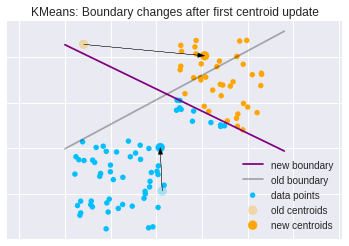

In [9]:
#                                                  CODE:
#                              --------------------------------------------

def update_centers(centroids, points):
    clusters = assign_cluster(centroids, points) # τρέχει πρώτα τη διαδικασία του assignment για να δει σε ποιο cluster ανήκει το κάθε παράδειγμα
    new_centroids = np.zeros(centroids.shape) # πίνακας που θα αποθηκευτούν οι νέες θέσεις των κέντρων
    for i in range(len(centroids)):
        cluster_points_idx = [j for j in range(len(clusters)) if clusters[j] == i] # βρίσκει τις θέσεις των σημείων που αντιστοιχούν στο cluster i
        if cluster_points_idx: # αν υπάρχουν σημεία που έχουν ανατεθεί στο κέντρο, αυτό ενημερώνεται
            cluster_points = points[cluster_points_idx] # παίρνουμε το slice των αντίστοιχων θέσεων
            new_centroids[i, 1] = cluster_points[:,1].sum() / len(cluster_points) # υπολογίζουμε τη νέα θέση των κέντρων
            new_centroids[i, 0] = cluster_points[:,0].sum() / len(cluster_points)
        else: # αλλιώς κρατάμε την παλιά του θέση
            new_centroids[i, :] = centroids[i, :]
    return new_centroids


#                                                PLOTTING:
#                              --------------------------------------------

# Υπολογίζουμε τις νέες θέσεις των κέντρων και με βάση αυτές το νέο decision boundary και τα νέα assignments
new_centroids = update_centers(centroids, points)
new_boundary = generate_perp_bisector(new_centroids)
new_colors = [map_colors[i] for i in assign_cluster(new_centroids, points)]

# Όπως είδαμε πριν δημιουργούμε τη γραφική παράσταση μετά την ενημέρωση των κέντρων
plt.scatter(points[:,0], points[:,1], c=new_colors, lw=0, s=30, label='data points')
plt.scatter(centroids[:,0], centroids[:,1], c=['orange', 'deepskyblue'], s=80, alpha=0.3, label='old centroids') # παλιά κέντρα
plt.scatter(new_centroids[:,0], new_centroids[:,1], c=['orange', 'deepskyblue'], s=80, label='new centroids')# νέα κέντρα
plt.plot(range(25), [new_boundary(x) for x in range(25)], c='purple', label='new boundary') # νέο boundary
plt.plot(range(25), [perp_bisector(x) for x in range(25)], c='black', label='old boundary', alpha=0.3) # παλιό boudary
plt.xlim([0,22])
plt.ylim([1,23])
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)
plt.title('KMeans: Boundary changes after first centroid update')
plt.legend(loc='lower right')
axes_scaling = plt.axis('equal')

# Σχεδιάζουμε και τα βελάκια που θα δούμε παρακάτω στο σχήμα
for i in range(k):
    plt.arrow(centroids[i,0], centroids[i,1], new_centroids[i,0]-centroids[i,0], new_centroids[i,1]-centroids[i,1],
             length_includes_head=True, head_width=0.5, color='black')

Τα βήματα 2 και 3 επαναλαμβάνονται μέχρι να μη μετακινούνται άλλο τα κέντρα. Ένα πολύ ωραίο visual example να δοκιμάσετε τον αλγόριθμο σε διάφορους τύπους δεδομένων και με διάφορες αρχικές συνθήκες θα βρείτε [εδώ](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/).

Για λόγους διευκόλυνσής μας θα γράψουμε τον αλγόριθμο αυτό σε μορφή κλάσης. Η κλάση αυτή θα αρχικοποιείται μόνο με την παράμετρο **k**, Θα έχει μια μέθοδο που θα ονομάσουμε `.fit()` η οποία θα δέχεται τα σημεία που θέλουμε να ομαδοποιήσουμε και θα εκπαιδεύει τον αλγόριθμο έως ότου έρθει σε σύγκλιση. Επίσης θα έχει μια μέθοδο `.predict()` η οποία θα δέχεται ένα ή περισσότερα σημεία και θα επιστρέφει σε ποια κλάση ανήκουν τα σημεία αυτά. 

In [0]:
class KMeans:
    
    def __init__(self, k, term_distance=0.05, max_steps=50, seed=None):
        # Constructor της κλάσης, δέχεται τις παραμέτρους και αρχικοποιεί το αντικείμενο
        self.k = k
        self.seed = seed
        self.history = [] 
        # Συνθήκες τερματισμού:
        self.term_distance = term_distance # ελάχιστη επιτρεπτή απόσταση μετακίνησης των κέντρων
        self.max_steps = max_steps         # μέγιστος επιτρεπτός αριθμός εποχών
        
    def initialize(self, data):
        # Βάζει k σημεία σε τυχαίες θέσεις στο χώρο που ορίζουν τα σημεία μας
        np.random.seed(self.seed)
        self.centroids = np.random.rand(self.k,2) * data.max()
        self.history = [self.centroids] # κρατάει ιστορικό με τις παλιές θέσεις των κέντρων
    
    def calc_distances(self, points):
        # Υπολογίζει τις αποστάσεις των σημείων points από τα κέντρα
        distances = np.zeros((len(self.centroids), len(points)))
        for i in range(len(self.centroids)):
            for j in range(len(points)):
                distances[i,j] = self.euclidean_distance(self.centroids[i], points[j])
        return distances
 
    def assign_cluster(self, points):
        # Συγκρίνει τις αποστάσεις των σημείων points από τα κέντρα και πραγματοποιεί την ανάθεση
        distances = self.calc_distances(points)
        return np.argmin(distances, axis=0)

    def update_centers(self, points):
        # Υπολογίζει τις νέες θέσεις των κέντρων
        clusters = self.assign_cluster(points)
        new_centroids = np.zeros(self.centroids.shape)
        for i in range(len(self.centroids)):
            cluster_points_idx = [j for j in range(len(clusters)) if clusters[j] == i]
            if cluster_points_idx:
                cluster_points = points[cluster_points_idx]
                new_centroids[i, 1] = cluster_points[:,1].sum() / len(cluster_points)
                new_centroids[i, 0] = cluster_points[:,0].sum() / len(cluster_points)
            else:
                new_centroids[i, :] = centroids[i, :]
        return new_centroids
    
    def fit(self, data):
        # Πραγματοποιεί όλη τη διαδικασία της εκπαίδευσης:
        # 1) αρχικοποιεί τα κέντρα με την initialize
        # 2, 3) υπολογίζει τις αποστάσεις και ενημερώνει τα κέντρα με την update_clusters
        # Επαναλαμβάνει τα βήματα 2 και 3 έως ότου ικανοποιηθεί η συνθήκη τερματισμού
        self.initialize(data)
        self.previous_positions = [self.centroids]
        step = 0
        cluster_movement = [self.term_distance + 1] * self.k
        while any([x > self.term_distance for x in cluster_movement]) and step < self.max_steps:
            new_centroids = self.update_centers(data)
            self.history.append(new_centroids)
            cluster_movement = [self.euclidean_distance(new_centroids[i,:], self.centroids[i,:]) for i in range(self.k)]
            self.centroids = new_centroids
            self.previous_positions.append(self.centroids)
            step += 1
            
    def predict(self, points):
        # Ελέγχει αν το points είναι πίνακας με πολλά σημεία ή οι συντεταγμένες ενός σημείου και πραγματοποιεί την ανάθεση 
        if isinstance(points, np.ndarray):
            if len(points.shape) == 2:
                return [np.argmin([self.euclidean_distance(point, centroid) for centroid in self.centroids]) for point in points]
        return np.argmin([self.euclidean_distance(points, self.centroids[i]) for i in range(self.k)])
        
    
    def fit_predict(self, points):
        # Τρέχει την fit και επιστρέφει τα assignments
        self.fit(points)
        return self.predict(points)
            
    @staticmethod
    def euclidean_distance(point1, point2):
        # Υπολογίζει την Ευκλείδεια απόσταση μεταξύ 2 σημείων
        return np.sqrt( (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2 )

Στην αρχή για να δούμε αν δουλεύει σωστά θα τρέξουμε μερικές επαναλήψεις μόνοι μας (χωρίς να κάνουμε χρήση της `.fit()`. Πρώτα αρχικοποιούμε τα **k** κέντρα των ομάδων.

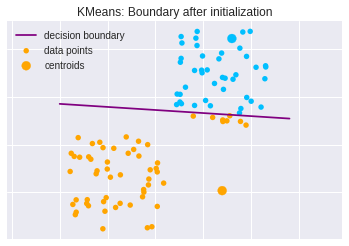

In [11]:
#                                                  CODE:
#                              --------------------------------------------

km = KMeans(2, seed=13)
km.initialize(points)

#                                                PLOTTING:
#                              --------------------------------------------

colors = [map_colors[i] for i in km.predict(points)]
decision_boundary = generate_perp_bisector(km.centroids)

plt.scatter(points[:,0], points[:,1], c=colors, lw=0, s=30, label='data points')
plt.scatter(km.centroids[:,0], km.centroids[:,1], c=['orange', 'deepskyblue'], s=80, label='centroids')
plt.plot(range(25), [decision_boundary(x) for x in range(25)], c='purple', label='decision boundary')
plt.xlim([0,22])
plt.ylim([1,23])
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)
plt.legend(loc='upper left')
plt.title('KMeans: Boundary after initialization')
axes_scaling = plt.axis('equal')

Και στη συνέχεια τρέχουμε μια επανάληψη και ενημερώνουμε τα κέντρα.

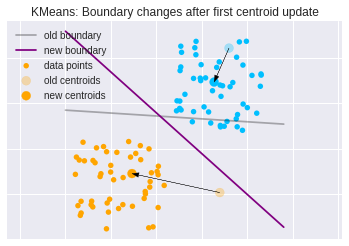

In [12]:
#                                                  CODE:
#                              --------------------------------------------

old = km.centroids
km.centroids = new = km.update_centers(points)

#                                                PLOTTING:
#                              --------------------------------------------

colors = [map_colors[i] for i in km.predict(points)]
decision_boundary_new = generate_perp_bisector(new)

plt.scatter(points[:,0], points[:,1], c=colors, lw=0, s=30, label='data points')
plt.scatter(old[:,0], old[:,1], c=['orange', 'deepskyblue'], s=80, label='old centroids', alpha=0.3)
plt.scatter(new[:,0], new[:,1], c=['orange', 'deepskyblue'], s=80, label='new centroids')
plt.plot(range(25), [decision_boundary(x) for x in range(25)], c='black', label='old boundary', alpha=0.3)
plt.plot(range(25), [decision_boundary_new(x) for x in range(25)], c='purple', label='new boundary')
plt.xlim([0,22])
plt.ylim([1,23])
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)
plt.legend(loc='upper left')
plt.title('KMeans: Boundary changes after first centroid update')
axes_scaling = plt.axis('equal')

for i in range(km.k):
    plt.arrow(old[i,0], old[i,1], new[i,0]-old[i,0], new[i,1]-old[i,1], length_includes_head=True, head_width=0.5, color='black')
    

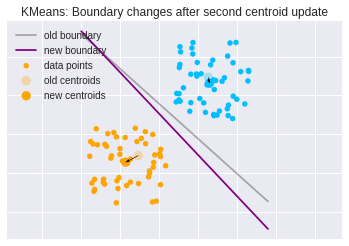

In [13]:
#                                                  CODE:
#                              --------------------------------------------

old = km.centroids
new = km.update_centers(points)

#                                                PLOTTING:
#                              --------------------------------------------

decision_boundary = decision_boundary_new
colors = [map_colors[i] for i in km.predict(points)]
decision_boundary_new = generate_perp_bisector(new)

plt.scatter(points[:,0], points[:,1], c=colors, lw=0, s=30, label='data points')
plt.scatter(old[:,0], old[:,1], c=['orange', 'deepskyblue'], s=80, label='old centroids', alpha=0.3)
plt.scatter(new[:,0], new[:,1], c=['orange', 'deepskyblue'], s=80, label='new centroids')
plt.plot(range(25), [decision_boundary(x) for x in range(25)], c='black', label='old boundary', alpha=0.3)
plt.plot(range(25), [decision_boundary_new(x) for x in range(25)], c='purple', label='new boundary')
plt.xlim([0,22])
plt.ylim([1,23])
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)
plt.legend(loc='upper left')
plt.title('KMeans: Boundary changes after second centroid update')    
axes_scaling = plt.axis('equal')

for i in range(km.k):
    plt.arrow(old[i,0], old[i,1], new[i,0]-old[i,0], new[i,1]-old[i,1], length_includes_head=True, head_width=0.3, color='black')

Τώρα που βλέπουμε ότι δουλεύει, μπορούμε να δοκιμάσουμε και τη μέθοδο `.fit()` η οποία αναλαμβάνει όλη τη διαδικασία εκπαίδευσης για όσες επαναλήψεις χρειαστεί.

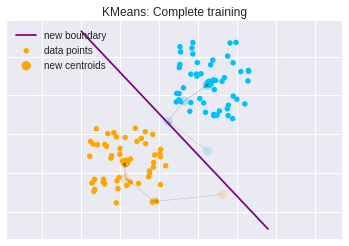

In [14]:
#                                                  CODE:
#                              --------------------------------------------

km = KMeans(2, seed=44)
km.fit(points)

#                                                PLOTTING:
#                              --------------------------------------------

colors = [map_colors[i] for i in km.predict(points)]
decision_boundary = generate_perp_bisector(km.centroids)

plt.scatter(points[:,0], points[:,1], c=colors, lw=0, s=30, label='data points')
plt.scatter(new[:,0], new[:,1], c=['orange', 'deepskyblue'], s=80, label='new centroids')
plt.plot(range(25), [decision_boundary_new(x) for x in range(25)], c='purple', label='new boundary')
plt.xlim([0,22])
plt.ylim([1,23])
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)
plt.legend(loc='upper left')
plt.title('KMeans: Complete training')
axes_scaling = plt.axis('equal')

# Χρησιμοποιούμε την km.history για να δούμε και να σχεδιάσουμε τις προηγούμενες θέσεις των κέντρων
steps = len(km.history)
for s in range(steps-2): # την τελευταία θέση (όπου s==steps-1) τη σχεδιάσαμε παραπάνω, την προ-τελευταία την αγνοούμε για 2 λόγους:
                         # 1) για να τερμάτισε σημαίνει ότι έχει μηδαμινή κίνηση από την τελευταία και
                         # 2) γιατί τα arrow πρέπει να είναι κατά 1 λιγότερα από τα σημεία
    plt.scatter(km.history[s][:,0], km.history[s][:,1], c=['orange', 'deepskyblue'], s=80, label='old centroids', alpha=1.0/(steps-s))

    for i in range(km.k):
        plt.arrow(km.history[s][i,0], km.history[s][i,1], km.history[s+1][i,0]-km.history[s][i,0], km.history[s+1][i,1]-km.history[s][i,1], length_includes_head=True, head_width=0.3, color='black', alpha=1.0/(steps-s))

Μόλις έχει εκπαιδευτεί το σύστημα, μπορούμε να χρησιμοποιήσουμε και την `.predict()` για να δούμε σε ποια ομάδα ανήκει το κάθε σημείο.

In [15]:
print(' (0,0)  belongs to cluster:', km.predict((0,0)))
print(' (5,5)  belongs to cluster:', km.predict((5,5)))
print('(10,10) belongs to cluster:', km.predict((10,10)))
print('(15,15) belongs to cluster:', km.predict((15,15)))
print('(20,20) belongs to cluster:', km.predict((20,20)))
print('(25,25) belongs to cluster:', km.predict([25,25]))

 (0,0)  belongs to cluster: 0
 (5,5)  belongs to cluster: 0
(10,10) belongs to cluster: 0
(15,15) belongs to cluster: 1
(20,20) belongs to cluster: 1
(25,25) belongs to cluster: 1


Τι θα γίνει όμως αν βάλουμε μεγαλύτερο **k** από αυτό που χρειάζεται;

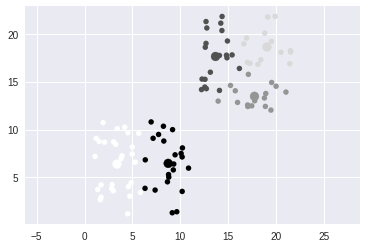

In [16]:
#                                                  CODE:
#                              --------------------------------------------

km = KMeans(5, seed=13)
km.fit(points)

#                                                PLOTTING:
#                              --------------------------------------------

# Ως colors μπορούμε για ευκολία να βάλουμε και τα index των assignments αντί για μία λίστα με χρώματα όπως προηγουμένως
plt.scatter(points[:,0], points[:,1], c=km.predict(points), s=30, lw=0)
plt.scatter(km.centroids[:,0], km.centroids[:,1], c=range(5), s=80)
axes_scaling = plt.axis('equal')

Ή αν έχουμε κάποιο πιο πολύπλοκο πρόβλημα όπου δεν ξέρουμε τι **k** να χρησιμοποιήσουμε;

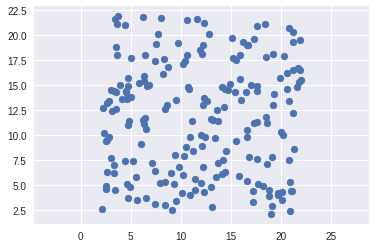

In [17]:
#                                                  CODE:
#                              --------------------------------------------

np.random.seed(77)

# Θα φτιάξουμε 4 ομάδες από 50 σημεία με κέντρα τις θέσεις (7,7), (7,17), (17,7) και (17,17)
# Θα δημιουργήσουμε τα σημεία, όμως, με πολύ μεγάλη διασπορά ώστε να μην φαίνονται οι ομάδες
# με το μάτι

lowb, highb, var = 2, 12, 10

p1 = np.random.rand(50,2) * var + lowb
p2 = np.random.rand(50,2) * var + highb

a = np.array([highb]*50)
b = np.array([lowb]*50)
c = np.zeros((50,2))
c[:,0], c[:,1] = a, b
p3 = np.random.rand(50,2) * var + c
c[:,1], c[:,0] = a, b
p4 = np.random.rand(50,2) * var + c

points = np.concatenate([p1, p2, p3, p4])

#                                                PLOTTING:
#                              --------------------------------------------

plt.scatter(points[:,0], points[:,1])
axes_scaling = plt.axis('equal')

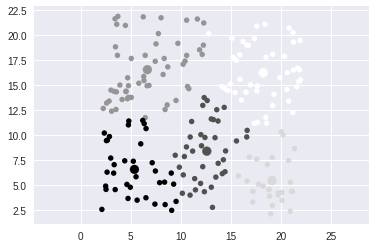

In [18]:
#                                                  CODE:
#                              --------------------------------------------

k = 5
km = KMeans(k, seed=77)
km.fit(points)

#                                                PLOTTING:
#                              --------------------------------------------

plt.scatter(points[:,0], points[:,1], c=km.predict(points), lw=0, s=30)
plt.scatter(km.centroids[:,0], km.centroids[:,1], c=range(k), s=80)
axes_scaling = plt.axis('equal')

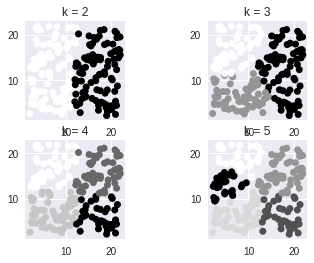

In [19]:
#                                                PLOTTING:
#                              --------------------------------------------

# Δημιουργούμε 4 subplots πάνω στο ίδιο διάγραμμα
f, ax = plt.subplots(2, 2)
seed = 55

# k = 2
km = KMeans(2, seed=seed)
ax[0, 0].scatter(points[:,0], points[:,1], c=km.fit_predict(points), lw=0)
ax[0, 0].set_title('k = 2')
ax[0, 0].set_aspect('equal')

# k = 3
km = KMeans(3, seed=seed)
ax[0, 1].scatter(points[:,0], points[:,1], c=km.fit_predict(points), lw=0)
ax[0, 1].set_title('k = 3')
ax[0, 1].set_aspect('equal')

# k = 4
km = KMeans(4, seed=seed)
ax[1, 0].scatter(points[:,0], points[:,1], c=km.fit_predict(points), lw=0)
ax[1, 0].set_title('k = 4')
ax[1, 0].set_aspect('equal')

# k = 5
km = KMeans(5, seed=seed)
ax[1, 1].scatter(points[:,0], points[:,1], c=km.fit_predict(points), lw=0)
ax[1, 1].set_title('k = 5')
ax[1, 1].set_aspect('equal')

## Αξιολόγηση Clustering

Θέλουμε να βρούμε έναν τρόπο να επιλέξουμε το βέλτιστο k για το προηγούμενό μας πρόβλημα. Θέλουμε, δηλαδή, έναν τρόπο να αξιολογήσουμε την επίδοση του αλγορίθμου.

Όπως ξέρουμε δεν υπάρχουν ετικέτες σε ένα πρόβλημα μη-επιβλεπόμενης μάθησης. Οι μετρικές που είδαμε στην επιβλεπόμενη μάθηση για την αξιολόγηση ενός αλγορίθμου (accuracy, confusion matrix, f1-score) χρειάζονται τις ετικέτες για να υπολογιστούν. Πώς μπορούμε, λοιπόν, να αξιολογήσουμε την επίδοση ενός αλγορίθμου clustering;

Το πιο απλό μέτρο που μπορούμε να σκεφτούμε είναι να συγκρίνουμε για κάθε cluster τη διασπορά των παραδειγμάτων του συγκεκριμένου cluster.

Για το cluster $C$ το παραπάνω μπορεί να υπολογιστεί ως εξής:

$$
I_C = \sum_{i \in C}{(x_i - \bar{x}_C)^2}
$$

όπου $x_i$ ένα παράδειγμα που ανήκει στο cluster $C$ με κέντρο $\bar{x}_C$.

Όσο πιο μικρό το μέτρο αυτό, τόσο μικρότερη διασπορά έχει το αντίστοιχο cluster, πράγμα επιθυμητό καθώς σημαίνει ότι το cluster είναι πιο "συμπαγές". Μετρικές σαν αυτή τις ονομάζουμε **inertia**. Για να υπολογίσω το συνολικό inertia, απλά προσθέτω τις διασπορές για όλα τα cluster.

$$
Ι = \sum_{C = 1}^k{I_C}
$$

Πολλές φορές το σταθμίζουμε και με τη συνολική διασπορά στο dataset. Ας δούμε το αντίστοιχο παράδειγμα με πριν με την υλοποίηση του [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) από το scikit-klearn...

2693.518419516413


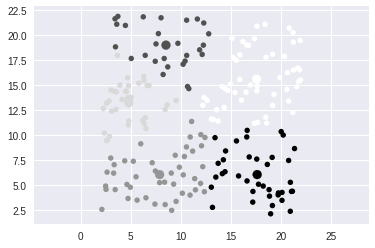

In [20]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.cluster import KMeans

k = 5
km = KMeans(k, random_state=99)
km.fit(points)

print(km.inertia_)

#                                                PLOTTING:
#                              --------------------------------------------

plt.scatter(points[:,0], points[:,1], c=km.predict(points), lw=0, s=30)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c=range(km.n_clusters), s=80)
axes_scaling = plt.axis('equal')

Όσο μικρότερο το inertia τόσο καλύτερο clustering έχει γίνει. Προφανώς θέλουμε να **ελαχιστοποιήσουμε** το κριτήριο αυτό. Ας τρέξουμε λοιπόν τον k-means για k από 1 μέχρι 100 να δούμε σε ποια τιμή ελαχιστοποιείται ο δείκτης αυτός.

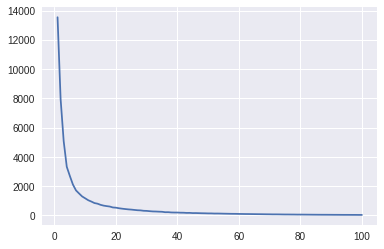

In [21]:
#                                                  CODE:
#                              --------------------------------------------

cluster_scores = []
for k in range(1, 101):
    km = KMeans(k, random_state=77)
    km.fit(points)
    cluster_scores.append(km.inertia_)

#                                                PLOTTING:
#                              --------------------------------------------

plt.plot(range(1, 101), cluster_scores)

Παρατηρούμε ότι το inertia μικραίνει όσο μεγαλώνει το $k$, και φτάνει στο 0 όταν $k=N$, όπου $N$ το πλήθος των παραδειγμάτων μας. Το να ορίσουμε ένα cluster για κάθε δείγμα είναι τετριμμένη λύση γιατί δεν μας βοηθάει να εξηγήσουμε τα δεδομένα, να εξάγουμε γνώση από αυτά που είναι ο στόχος στην μη επιβλεπόμενη μάθηση.

Άρα δεν μπορεί να μας βοηθήσει το κριτήριο αυτό για τον υπολογισμό του βέλτιστου k.

Ένα **εμπειρικό** κριτήριο που μπορεί να βοηθήσει είναι αυτό που αποκαλούμε [elbow][1]. Κοιτάμε δηλαδή στη γραφική του inertia ή του variance, σε ποιο k σχηματίζει έναν αγκώνα η γραφική. Αυτό υπολογίζεται κοιτάζοντας και τη δεύτερη παράγωγο της αντίστοιχης γραφικής.

[1]: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

Text(5,4500,'elbow')

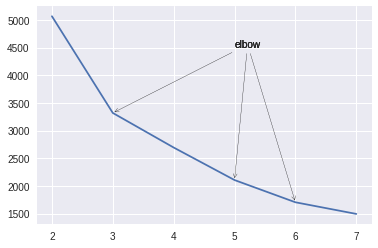

In [22]:
#                                                PLOTTING:
#                              --------------------------------------------

plt.plot(range(2,8), cluster_scores[2:8])
plt.annotate("elbow", xy=(3, cluster_scores[3]), xytext=(5, 4500),arrowprops=dict(arrowstyle="->"))
plt.annotate("elbow", xy=(5, cluster_scores[5]), xytext=(5, 4500),arrowprops=dict(arrowstyle="->"))
plt.annotate("elbow", xy=(6, cluster_scores[6]), xytext=(5, 4500),arrowprops=dict(arrowstyle="->"))

Δηλαδή στη συγκεκριμένη περίπτωση θα ήταν $k=3$, $k=5$ ή $k=6$.

Για να αποκτήσουμε μια πιο "αντικειμενική" εικόνα υπάρχουν 2 βασικοί τρόποι [αξιολόγησης αλγορίθμων clustering](https://en.wikipedia.org/wiki/Cluster_analysis#Evaluation_and_assessment): η εξωτερική (external) και η εσωτερική (internal) αξιολόγηση.

- Εξωτερική αξιολόγηση (Extrinsic evaluation): Απαιτεί την εκτέλεση του αλγορίθμου σε ένα πρόβλημα επιβλεπόμενης μάθησης (που έχουμε τις ετικέτες δλδ ποιο δείγμα ανήκει σε ποια ομάδα) και την "εξωτερική" του αξιολόγηση με βάση αυτές. Δεν αποτελεί τυπική περίπτωση clustering και δεν θα την εξετάσουμε περισσότερο.
- Εσωτερική αξιολόγηση (Intrinsic evaluation): Απαιτεί την ανάλυση της δομής ή της ευστάθειας των παραγόμενων από τον αλγόριθμο clusters.

### Εσωτερική Αξιολόγηση Clustering

- [Dunn index](https://en.wikipedia.org/wiki/Dunn_index):
Ο αριθμητής του dunn index είναι ένα μέτρο της **μικρότερης απόστασης μεταξύ δυο cluster** (π.χ. απόσταση μεταξύ των κέντρων τους).  
Στον παρονομαστή μπαίνει ένα μέτρο του **μεγέθους του μεγαλύτερου cluster** (π.χ. η απόσταση μεταξύ των 2 πιο απομακρυσμένων παραδειγμάτων που ανήκουν στον cluster αυτό).

$$
DI= \frac{ min \left( δ \left( C_i, C_j \right) \right)}{ max \, Δ_p }
$$

όπου $C_i, C_j$ είναι δυο τυχαία κέντρα cluster, $δ \left( C_i, C_j \right)$ είναι ένα μέτρο της απόστασής τους και $Δ_p$ είναι ένα μέτρο της "διαμέτρου" του cluster $p$, όπου $p \in [0,k]$.

- [Silhouette coefficient][1]:
$$
s \left( i \right) = \frac{b \left( i \right) -a \left( i \right) }{max \left( a \left( i \right) , b \left( i \right) \right)}
$$

Έστω $i$ ένα δεδομένο (point) οποιασδήποτε ομάδας. 

Το $a(i)$ είναι η μέση απόσταση του $i$ από όλα τα υπόλοιπα δεδομένα του clusters στο οποίο ανήκει. Όσο μικρότερο είναι το $a(i)$, τόσο περισσότερο ομοιάζει το $i$ στα υπόλοιπα δείγματα του cluster.

To $b(i)$ είναι η μικρότερη μέση απόσταση του $i$ από όλα τα σημεία σε οποιοδήποτε άλλο cluster στο οποίο το $i$ δεν ανήκει. Το cluster με την μικρότερη μέση απόσταση από το $i$ θεωρείται το "γειτονικό" cluster (η δεύτερη καλύτερη επιλογή ομαδοποίησης).

Μικρό $a(i)$ σημαίνει ότι το cluster του $i$ είναι συμπαγές ενώ μεγάλο $b(i)$ σημαίνει ότι το $i$ έχει μεγάλη απόσταση από το κοντινότερό του cluster.

Το εύρος τιμών που μπορεί να πάρει το $s(i)$ είναι από -1 έως 1. Όσο πιο μεγάλο, τόσο πιο ξεκάθαρα τα clusters μεταξύ τους. Για να είναι το $s(i) \approx 1$, πρέπει το $b(i) >> a(i)$.

Για να αξιολογήσουμε τον αλγόριθμό μας συνήθως παίρνουμε το μέσο όρο των $s(i)$ για όλα τα $i$.

[1]: https://en.wikipedia.org/wiki/Silhouette_(clustering)

Maximum average silhouette score for k = 61


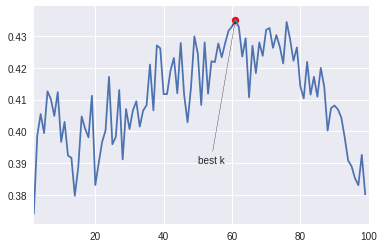

In [23]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 100):
    km = KMeans(k, random_state=77)
    km.fit(points)
    preds = km.predict(points)
    silhouette_scores.append(silhouette_score(points, preds))

#                                                PLOTTING:
#                              --------------------------------------------

plt.plot(range(2, 100), silhouette_scores)
best_k = np.argmax(silhouette_scores) + 2 # +2 γιατί ξεκινάμε το range() από k=2 και όχι από 0 που ξεκινάει η αρίθμηση της λίστας
plt.scatter(best_k, silhouette_scores[best_k-2], color='r') # για τον ίδιο λόγο το καλύτερο k είναι αυτό 2 θέσεις παρακάτω από το index της λίστας
plt.xlim([2,100])
plt.annotate("best k", xy=(best_k, silhouette_scores[best_k-2]), xytext=(50, 0.39),arrowprops=dict(arrowstyle="->")) # annotation
print('Maximum average silhouette score for k =', best_k)

Το αποτέλεσμα του clustering για $k=61$ φαίνεται στο παρακάτω σχήμα.

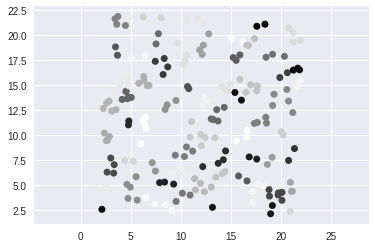

In [24]:
#                                                  CODE:
#                              --------------------------------------------

preds = KMeans(best_k, random_state=77).fit_predict(points)

#                                                PLOTTING:
#                              --------------------------------------------

plt.scatter(points[:,0], points[:,1], c=preds, lw=0)
axes_scaling = plt.axis('equal')

Το αποτέλεσμα αυτό μπορεί να μην είναι επιθυμητό λόγω του μεγάλου αριθμού των cluster που δεν μας βοηθά να κατανοήσουμε τα δεδομένα. Αυτό που κάνουμε πρακτικά είναι να ορίσουμε ένα μέγιστο $k$ και να ψάξουμε το μέγιστο silhouette score μέχρι αυτό το μέγιστο $k$. Εδώ για παράδειγμα θέτουμε μέγιστο 10 ομάδες:

A good value for k is: k = 6


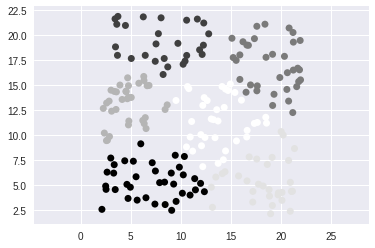

In [25]:
#                                                  CODE:
#                              --------------------------------------------

good_k = np.argmax(silhouette_scores[:10])+2

#                                                PLOTTING:
#                              --------------------------------------------

plt.scatter(points[:,0], points[:,1], c=KMeans(good_k, random_state=77).fit_predict(points), lw=0)
axes_scaling = plt.axis('equal')
print('A good value for k is: k =', good_k)

Αν θέλουμε να δούμε και το $k$ αυτό σε σχέση με το βέλτιστο:

Text(10,0.43,'good k')

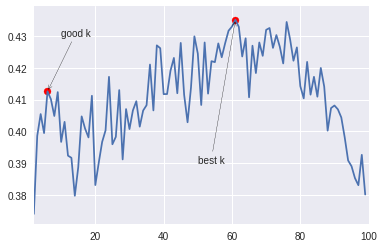

In [26]:
#                                                PLOTTING:
#                              --------------------------------------------

plt.plot(range(2, 100), silhouette_scores)
best_k = np.argmax(silhouette_scores)+2
plt.scatter([good_k, best_k], [silhouette_scores[good_k-2], silhouette_scores[best_k-2]], color='r')
plt.xlim([2,100])
plt.annotate("best k", xy=(best_k, silhouette_scores[best_k-2]), xytext=(50, 0.39),arrowprops=dict(arrowstyle="->"))
plt.annotate("good k", xy=(good_k, silhouette_scores[good_k-2]), xytext=(10, 0.43),arrowprops=dict(arrowstyle="->"))

Μια άλλη στρατηγική θα ήταν να ψάξουμε τα μεγαλύτερα $k$ και να δούμε από αυτά ποιο μας κάνει περισσότερο.

For k = 19, the average silhouette score is: 0.41120723799154857.
For k = 9 , the average silhouette score is: 0.41236225194448023.
For k = 6 , the average silhouette score is: 0.41259141274861577.


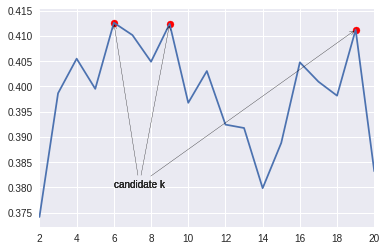

In [27]:
#                                                PLOTTING:
#                              --------------------------------------------

topN = 3
plt.plot(range(2, 22), silhouette_scores[:20])
candidate_k = np.argpartition(silhouette_scores[:20], -topN)[-topN:]
plt.scatter([k+2 for k in candidate_k], [silhouette_scores[k] for k in candidate_k], color='r')
plt.xlim([2,20])
for k in candidate_k:
    plt.annotate("candidate k", xy=(k+2, silhouette_scores[k]), xytext=(6, 0.38),arrowprops=dict(arrowstyle="->"))
    print('For k = {:<2}, the average silhouette score is: {}.'.format(k+2, silhouette_scores[k]))

Το scikit-klearn διαθέτει διάφορες [μετρικές](http://scikit-learn.org/stable/modules/classes.html#clustering-metrics) για την αξιολόγηση αλγορίθμων clustering, όμως θέλει προσοχή γιατί δεν είναι όλες για εσωτερική αξιολόγηση. Ακόμα και από αυτές που είναι για εσωτερική αξιολόγηση, όσες βασίζονται στον υπολογισμό διασποράς των cluster (intra-cluster variance) και των παραδειγμάτων στο cluster (inter-cluster variance) δεν μπορούν να χρησιμοποιηθούν για τον υπολογισμό του $k$.

Π.χ η μετρική [Calinski-Harabaz](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html):

$$
CH \left( x \right) = \frac{B \left( x \right) / \left( x - 1 \right) }{W \left( x \right) / \left( n - x \right)}
$$

Όπου $B \left( x \right)$ μια μετρική διασποράς ανάμεσα στα cluster (π.χ. το άθροισμα των τετραγώνων των αποστάσεων μεταξύ των κέντρων των cluster) και $W \left( x \right)$ μια μετρική διασποράς μέσα στο cluster (π.χ. το άθροισμα των τετραγώνων των αποστάσεων ανάμεσα στα παραδείγματα του ίδιου cluster).


Maximum Calinski Harabaz score for k = 99


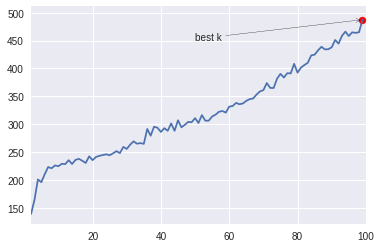

In [28]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.metrics import calinski_harabaz_score

ch_scores = []
for k in range(2, 100):
    km = KMeans(k, random_state=77)
    km.fit(points)
    preds = km.predict(points)
    ch_scores.append(calinski_harabaz_score(points, preds))

#                                                PLOTTING:
#                              --------------------------------------------
    
plt.plot(range(2, 100), ch_scores)
ch_k = np.argmax(ch_scores)+2
plt.scatter(ch_k, ch_scores[ch_k-2], color='r')
plt.xlim([2,100])
plt.annotate("best k", xy=(ch_k, ch_scores[ch_k-2]), xytext=(50, 450),arrowprops=dict(arrowstyle="->"))
print('Maximum Calinski Harabaz score for k =', ch_k)

## Επιπλέον παρατηρήσεις

### Eπιλογή του k με gap statistics

Εκτός από τις μεθόδους elbow και silhouette μπορεί να χρησιμοποιηθεί και η μέθοδος [gap statistics](https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/) (παράδειγμα σε Python)

### Αρχικοποίηση

Η σωστή αρχικοποίηση των κέντρων έχει μεγάλη σημασία για το αποτέλεσμα του αλγορίθμου. Ας δούμε ένα παράδειγμα. 

Text(0.5,1,'KMeans: Centroid Initialization')

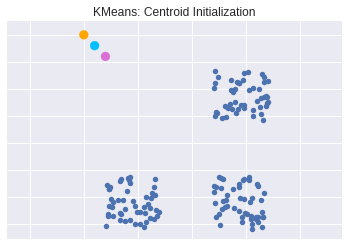

In [29]:
#                                                  CODE:
#                              --------------------------------------------

# Θα φτιάξουμε 3 ομάδες των 50 σημείων με κέντρα τις θέσεις (7,7), (17,7) και (17,17)
np.random.seed(77)

lowb, highb, var = 2, 12, 5

p1 = np.random.rand(50,2) * var + lowb
p2 = np.random.rand(50,2) * var + highb

a = np.array([highb]*50)
b = np.array([lowb]*50)
c = np.zeros((50,2))
c[:,0], c[:,1] = a, b
p3 = np.random.rand(50,2) * var + c

points = np.concatenate([p1, p2, p3])

# Τοποθετούμε 3 κέντρα στις θέσεις (0,20), (1,19) και (2,18)
centroids = np.array([[0,20], [1,19], [2,18]])

#                                                PLOTTING:
#                              --------------------------------------------

map_colors = {0:'orange', 1:'deepskyblue', 2:'orchid'}
color_list = ['orange', 'deepskyblue', 'orchid']

plt.scatter(points[:,0], points[:,1], lw=0, s=30, label='data points')
plt.scatter(centroids[:,0], centroids[:,1], c=color_list, s=80, label='centroids')
plt.xlim([-1,18])
plt.ylim([1,23])
axes_scaling = plt.axis('equal')
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)
plt.title('KMeans: Centroid Initialization')

Όπως βλέπουμε, έχουμε 3 ξεκάθαρες ομάδες και 3 κέντρα. Κανονικά θα θέλαμε να πέσει ένα κέντρο πάνω σε κάθε ομάδα. Τρέχουμε μια εποχή του αλγορίθμου να δούμε πώς θα τα πάει.

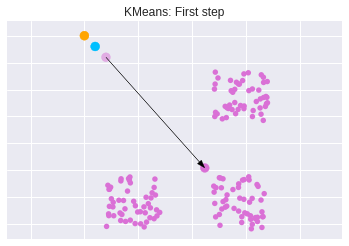

In [30]:
#                                                  CODE:
#                              --------------------------------------------

new_centroids = update_centers(centroids, points) 

#                                                PLOTTING:
#                              --------------------------------------------

colors = [map_colors[i] for i in assign_cluster(new_centroids, points)]
plt.scatter(points[:,0], points[:,1], c=colors, lw=0, s=30, label='data points')
plt.scatter(centroids[:,0], centroids[:,1], c=color_list, s=80, label='centroids', alpha=0.5)
plt.scatter(new_centroids[:,0], new_centroids[:,1], c=color_list, s=80, label='centroids')
plt.xlim([-1,18])
plt.ylim([1,23])
axes_scaling = plt.axis('equal')
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)
plt.title('KMeans: First step')
plt.arrow(centroids[2,0], centroids[2,1], new_centroids[2,0]-centroids[2,0], new_centroids[2,1]-centroids[2,1], 
         length_includes_head=True, head_width=0.5, color='black')

Η πρώτη εποχή ενημέρωσε το ένα από τα 3 κέντρα. Ας συνεχίσουμε τη διαδικασία...

Text(0.5,1,'KMeans: N step')

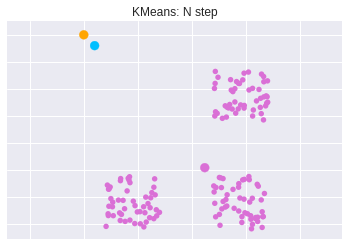

In [31]:
#                                                  CODE:
#                              --------------------------------------------

centroids = new_centroids
new_centroids = update_centers(centroids, points) 

#                                                PLOTTING:
#                              --------------------------------------------

colors = [map_colors[i] for i in assign_cluster(new_centroids, points)]

plt.scatter(points[:,0], points[:,1], c=colors, lw=0, s=30, label='data points')
plt.scatter(new_centroids[:,0], new_centroids[:,1], c=color_list, s=80, label='centroids')
plt.xlim([-1,18])
plt.ylim([1,23])
axes_scaling = plt.axis('equal')
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)
plt.title('KMeans: N step')

Όσες φορές και να τρέξουμε το παραπάνω κελί, δεν θα μετακινηθούν τα κέντρα. Σχεδιάζοντας και το decision boundary μπορούμε να το καταλάβουμε αυτό καλύτερα.

Text(0.5,1,'KMeans: Decision Boundary')

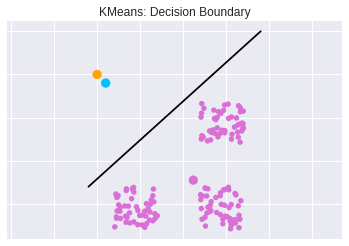

In [32]:
#                                                PLOTTING:
#                              --------------------------------------------

decision_boundary = generate_perp_bisector(centroids[1:,:])
plt.scatter(points[:,0], points[:,1], c=colors, lw=0, s=30, label='data points')
plt.scatter(new_centroids[:,0], new_centroids[:,1], c=color_list, s=80, label='centroids')
plt.plot(range(-1,20), decision_boundary(range(-1,20)), c='black', label='decision boundary')
plt.xlim([-1,18])
plt.ylim([1,23])
axes_scaling = plt.axis('equal')
plt.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelbottom=False, labelleft=False)
plt.title('KMeans: Decision Boundary')

Επειδή όλα τα παραδείγματα έχουν ανατεθεί στο 1 από τα 3 clusters, τα υπόλοιπα 2 είναι αδύνατο να ενημερωθούν. Το πρόβλημα στην περίπτωση αυτή ήταν η κακή αρχικοποίηση των κέντρων. Η πιο γνωστή τεχνική για την αρχικοποίηση των κέντρων είναι το [K-means++](https://en.wikipedia.org/wiki/K-means%2B%2B).

Η συγκεκριμένη τεχνική είναι και η προεπιλεγμένη στην υλοποίηση του scikit-learn. Επίσης το scikit-learn τρέχει τον αλγόριθμο 10 φορές για διαφορετικές αρχικές θέσεις και επιλέγει το αποτέλεσμα που ελαχιστοποιεί το inertia. 

### Πολυπλοκότητα

Η μέση χρονική πολυπλοκότητα του αλγορίθμου K-means εξαρτάται γραμμικά από:

- Τον αριθμό των κέντρων **k**.
- Τον αριθμό των παραδειγμάτων **N**.
- Τον αριθμό των διαστάσεων του κάθε παραδείγματος **d**.
- Τον αριθμό των εποχών που θα τρέξει μέχρι να συγκλίνει **i**.

$$
O \left( k \cdot N \cdot d \cdot i \right)
$$

Στην πράξη ο K-means είναι ένας από τους **γρηγορότερους** αλγορίθμους clustering που έχουμε. To πρόβλημά του είναι ότι κολλάει πολύ εύκολα σε **τοπικά ελάχιστα** (όπως είδαμε πριν με την κακή αρχικοποίηση).

Η αρχικοποίηση του αλγορίθμου με τη χρήση του k-means++ φέρει μια επιπλέον πολυπλοκότητα στο πρόβλημά μας, όμως επειδή βάζει τα κέντρα πιο στρατηγικά στο χώρο μπορεί να τερματίσει τον αλγόριθμο σε λιγότερες εποχές (πέρα από το καλύτερο clustering που επιτυγχάνει). Είναι προφανές πως αν τρέξουμε τον αλγόριθμο πολλές φορές (όπως κάνει το scikit-learn) για να επιτύχουμε τη βέλτιστη απόδοση, θα πάρει παραπάνω χρόνο.

### Σύγκριση με άλλους αλγορίθμους clustering

Ο αλγόριθμος k-means κατατάσεται στην κατηγορία των **centroid-based hard clustering** αλγορίθμων. 

#### Hard vs soft clustering

Υπάρχουν 2 κατηγορίες αλγορίθμων clustering με βάση το αποτέλεσμα, οι **hard** και οι **soft (ή fuzzy)**. Οι πρώτοι, όπως και ο k-means, κατατάσσουν το κάθε παράδειγμα σε μια ξεχωριστή κατηγορία, ενώ οι δεύτεροι δίνουν μια πιθανότητα να ανήκει στην κάθε κατηγορία.

Ένα παράδειγμα **soft clustering** φαίνεται παρακάτω:
![](https://knowm.org/wp-content/uploads/EM-density-data1.png)

Ένα παράδειγμα τέτοιου αλγορίθμου είναι ο [Expectation-Maximization (ΕΜ)](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm).

#### Ιεραρχικό clustering

Το ιεραρχικό clustering δημιουργεί μια ολόκληρη ιεραρχία απο clusters. Με αυτόν τον τρόπο, κάθε παράδειγμα μπορεί να ανήκει σε πολλά cluster, διαφορετικών ιεραρχιών.

![](http://www.statisticshowto.com/wp-content/uploads/2016/11/clustergram.png)